# Exploratory data analysis

## Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
from katlas.core import *

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Overlap between sources

In [ ]:
# direct concatenate of all source sequence
df=pd.read_parquet('raw/combine_source.parquet')

In [ ]:
# unique substrate site with source split by | 
df_group=pd.read_parquet('raw/combine_source_grouped.parquet')

In [ ]:
def plot_overlap(df_concat,source_col='source',id_col='kin_sub_site',figsize=(7,5),title="Overlap of Unique KS Pairs Between Sources"):
    source_ids = df_concat.groupby(source_col)[id_col].apply(set).to_dict()
    sources = list(source_ids.keys())
    
    overlap_matrix = pd.DataFrame(index=sources, columns=sources, dtype=int)
    for src1 in sources:
        for src2 in sources:
            if src1 == src2:
                overlap_matrix.loc[src1, src2] = len(source_ids[src1])
            else:
                overlap_matrix.loc[src1, src2] = len(source_ids[src1].intersection(source_ids[src2]))
    
    mask = np.triu(np.ones_like(overlap_matrix, dtype=bool), k=1)

    overlap_matrix = overlap_matrix.astype(int)
    
    vmin = np.min(overlap_matrix[overlap_matrix > 0])  # Smallest nonzero value
    vmax = np.max(overlap_matrix)
    
    plt.figure(figsize=figsize)
    sns.heatmap(overlap_matrix, 
                annot=True, 
                mask=mask, 
                fmt=",", 
                # vmin=1, vmax=1,
                norm=LogNorm(vmin=vmin, vmax=vmax),
                cmap="Blues", 
                cbar=False, 
                linewidths=1, 
                linecolor='white')

    plt.title(title)

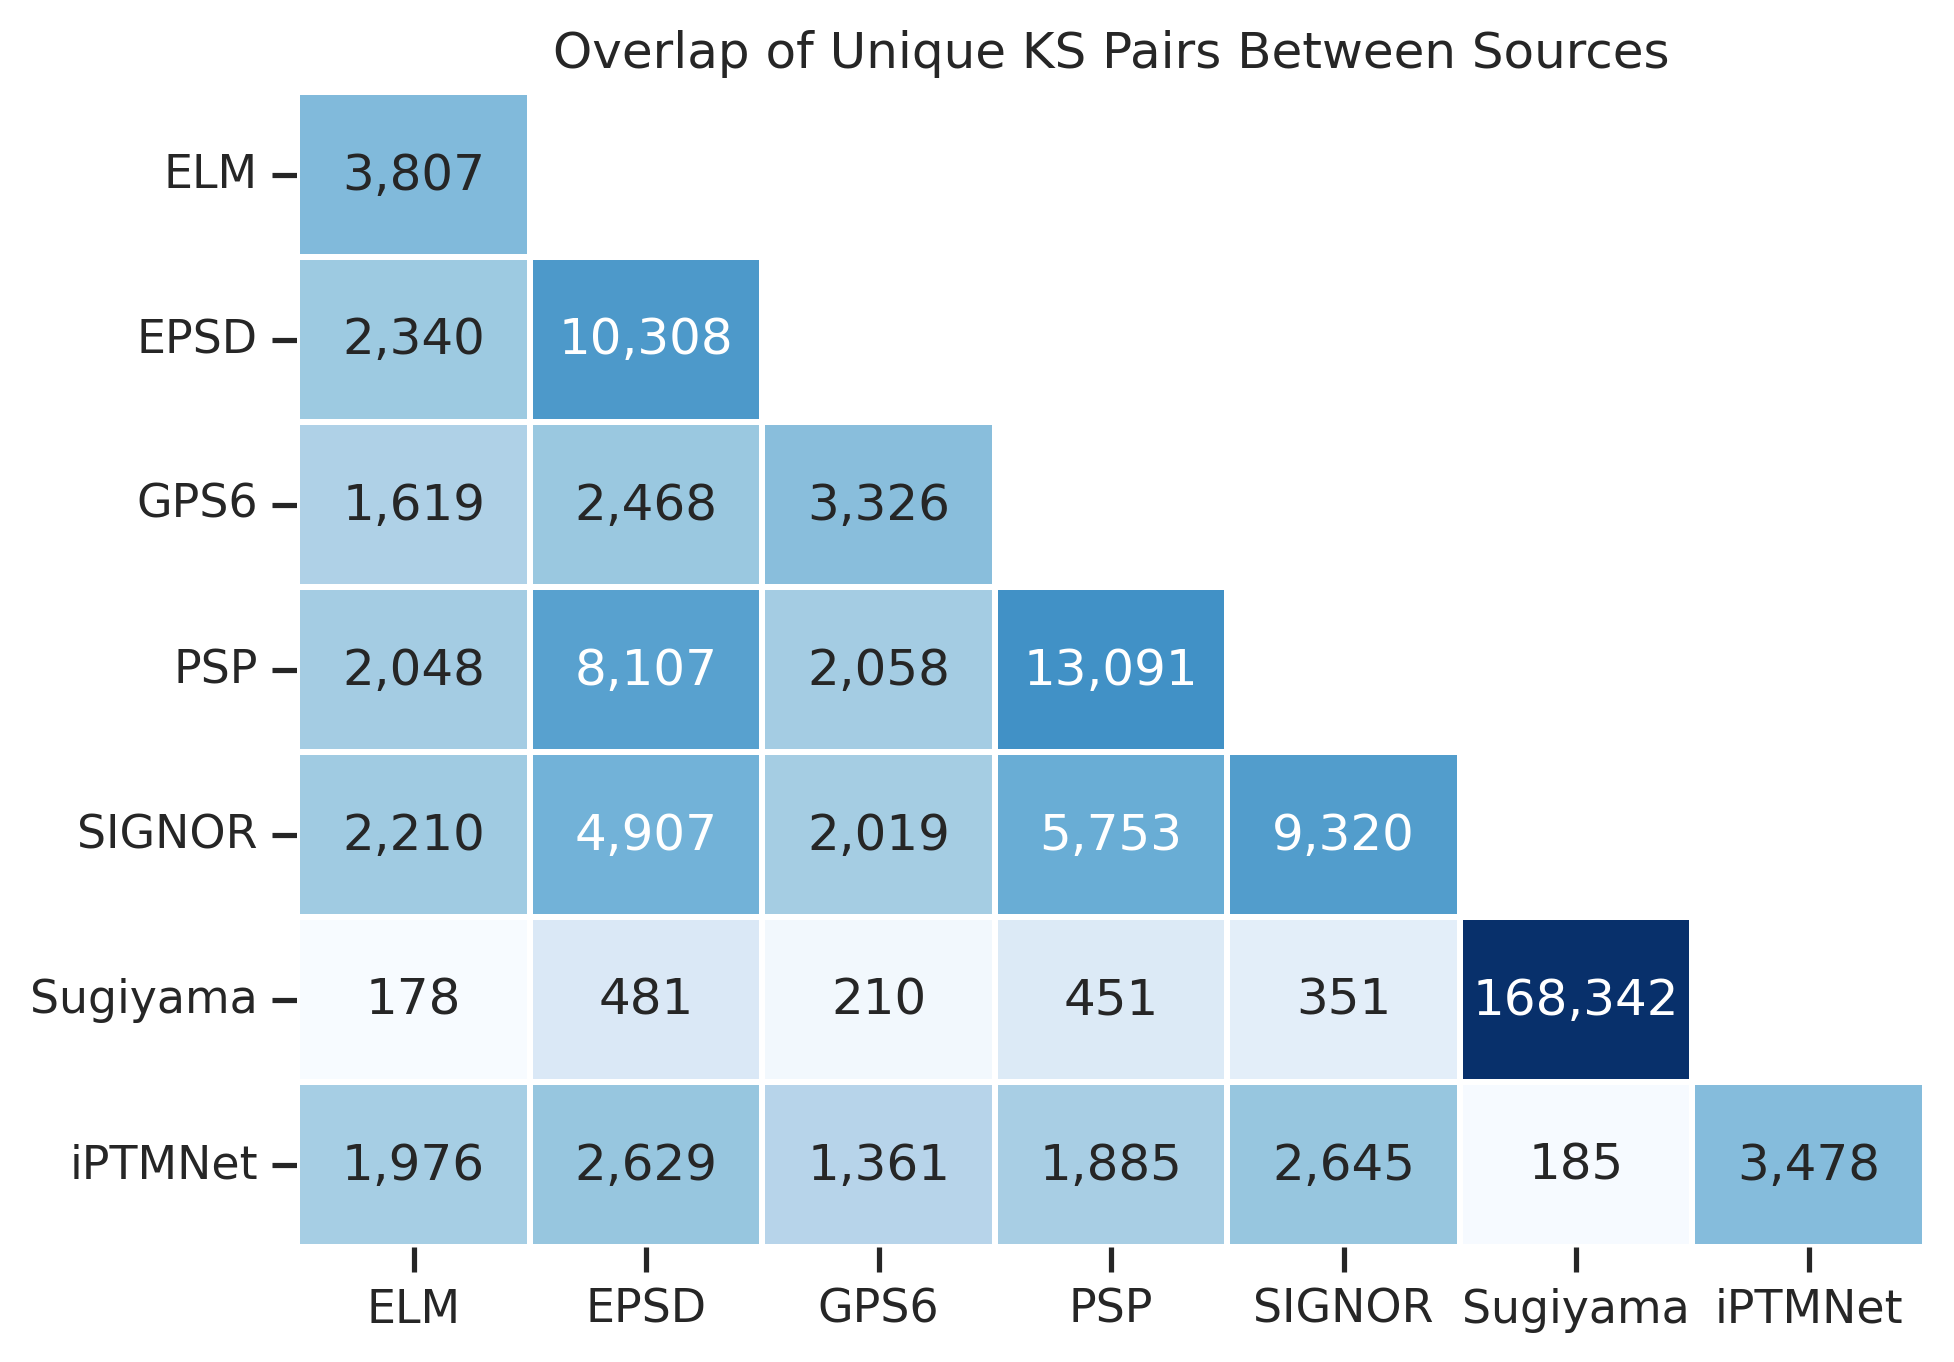

In [ ]:
plot_overlap(df)

In [ ]:
df.site.str[0].value_counts()

site
Y    92088
S    84341
T    35243
Name: count, dtype: int64

In [ ]:
df_st = df[df.site.str[0]!='Y']
df_y = df[df.site.str[0]=='Y']

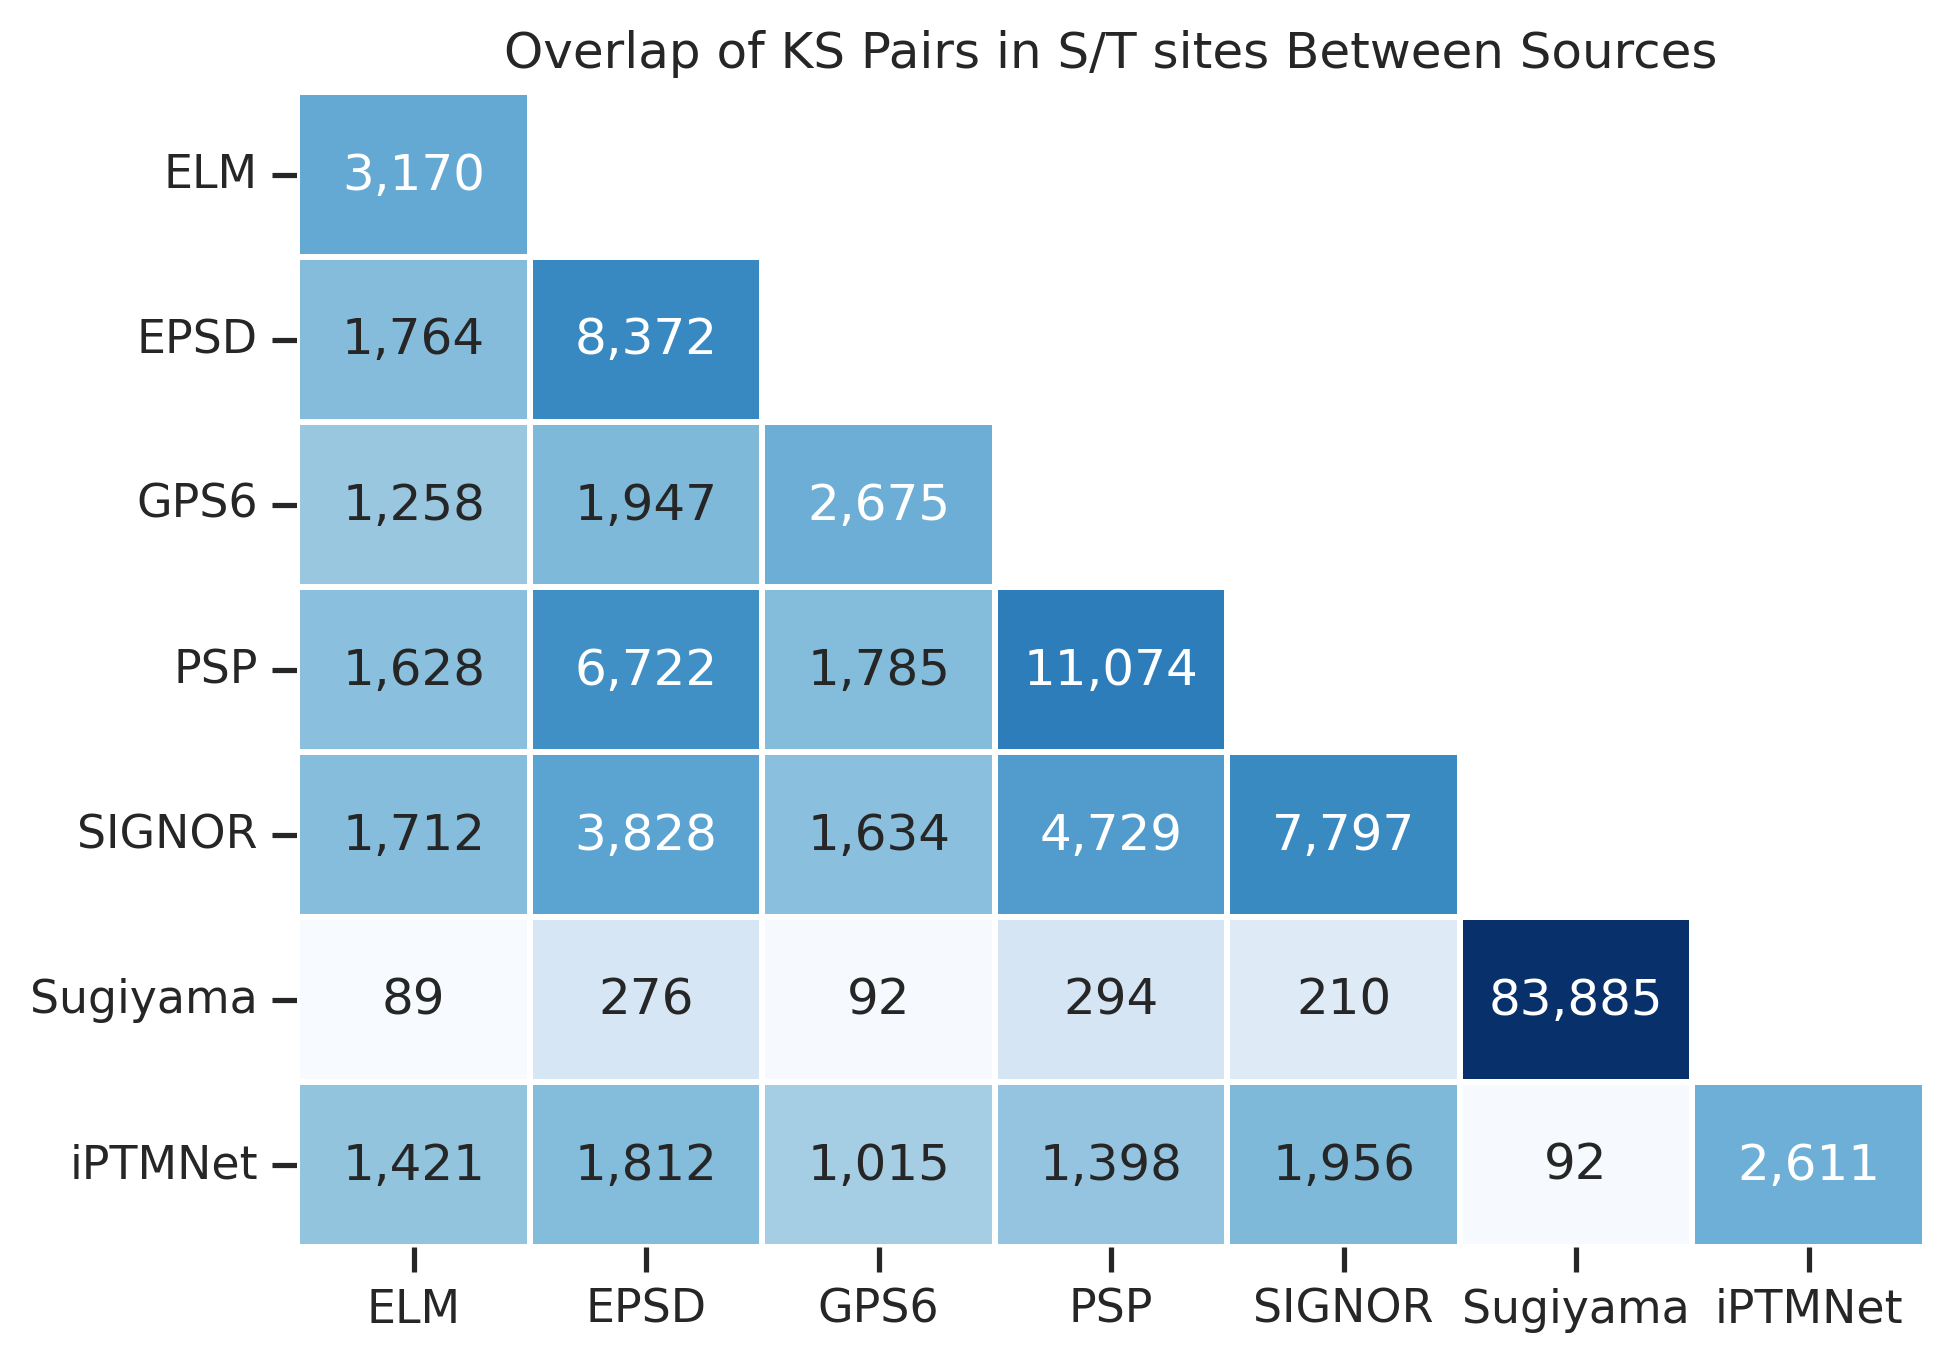

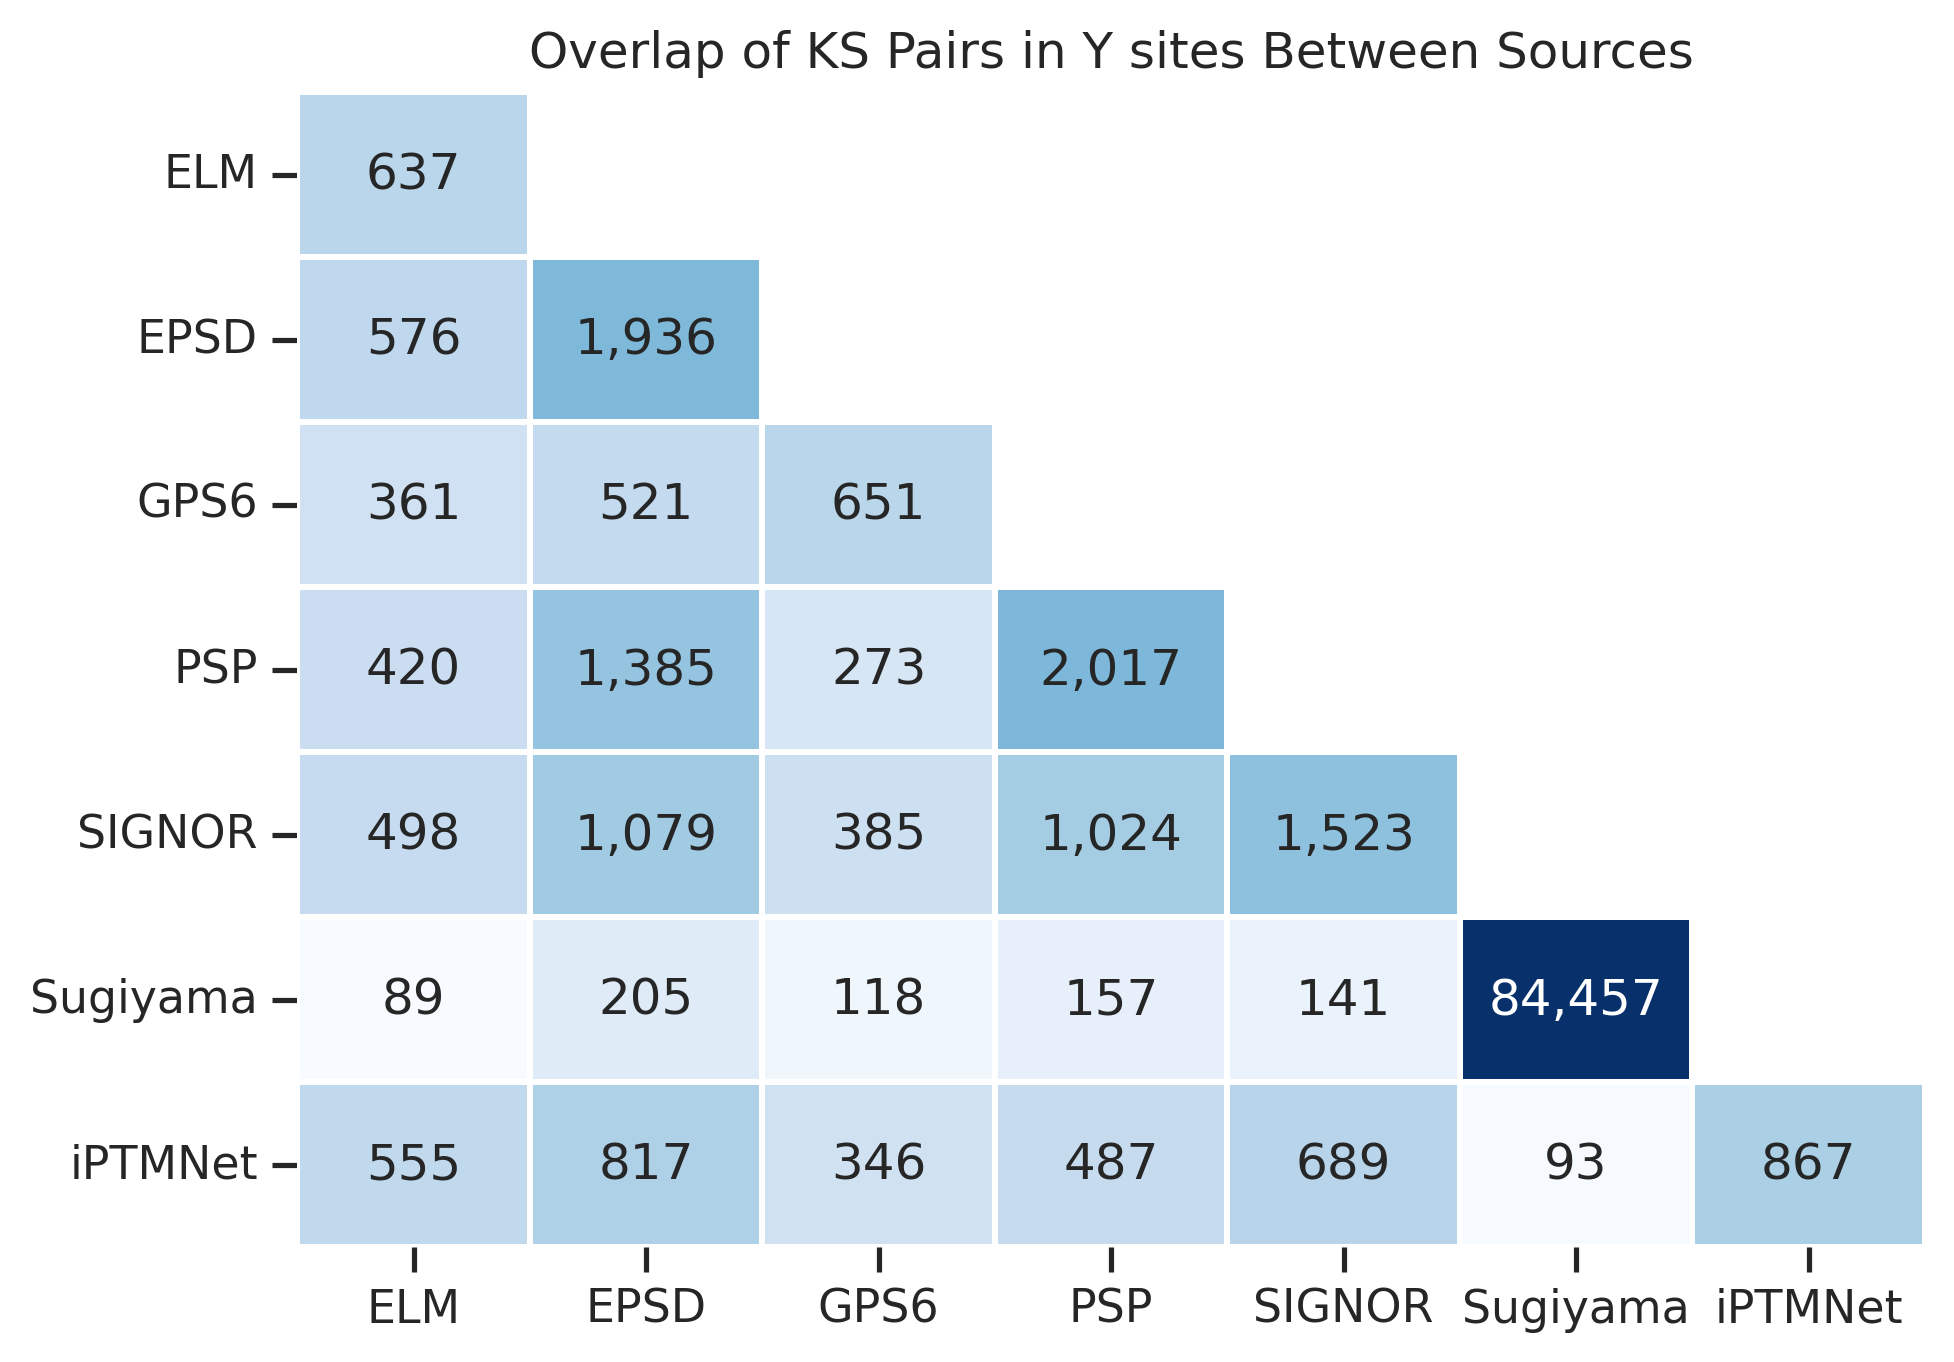

In [ ]:
plot_overlap(df_st,title="Overlap of KS Pairs in S/T sites Between Sources")
plot_overlap(df_y,title="Overlap of KS Pairs in Y sites Between Sources")

## Overlap of phosphosites with human phosphoproteome

In [ ]:
# data = Data.get_combine_site_phosphorylated()

In [ ]:
df=pd.read_parquet('raw/combine_source.parquet')
data = pd.read_parquet('raw/human_phosphoproteome.parquet')

In [ ]:
data = data.rename(columns={'uniprot':'substrate_uniprot'})

In [ ]:
def get_key(df):
    df = df.copy()
    print('original shape:',df.shape)
    df['sub_site']=df['substrate_uniprot']+'_'+df['site']
    df = df.drop_duplicates(subset='sub_site')
    print('after removing duplicates',df.shape)
    return df

In [ ]:
data_site = get_key(data)
df_site=get_key(df)

original shape: (119955, 11)
after removing duplicates (119955, 11)
original shape: (211672, 7)
after removing duplicates (29811, 8)


In [ ]:
data_site = data_site[['sub_site']].copy()
df_site = df_site[['sub_site']].copy()

data_site['source']='Human Phosphoprotome'
df_site['source']='KS Datasets'

df_concat = pd.concat([data_site,df_site],ignore_index=True)

In [ ]:
df_concat_group = df_concat.groupby('sub_site')['source'].agg(lambda x: '|'.join(x)).reset_index()

In [ ]:
df_concat_group.source.value_counts()

source
Human Phosphoprotome                102032
Human Phosphoprotome|KS Datasets     17923
KS Datasets                          11888
Name: count, dtype: int64

In [ ]:
# plot_overlap(df_concat,source_col='source',id_col='sub_site',figsize=(4,2),
#              title="Overlap of Unique Substrate Sites Between Datasets")

Venn diagram:

In [ ]:
# pip install matplotlib_venn

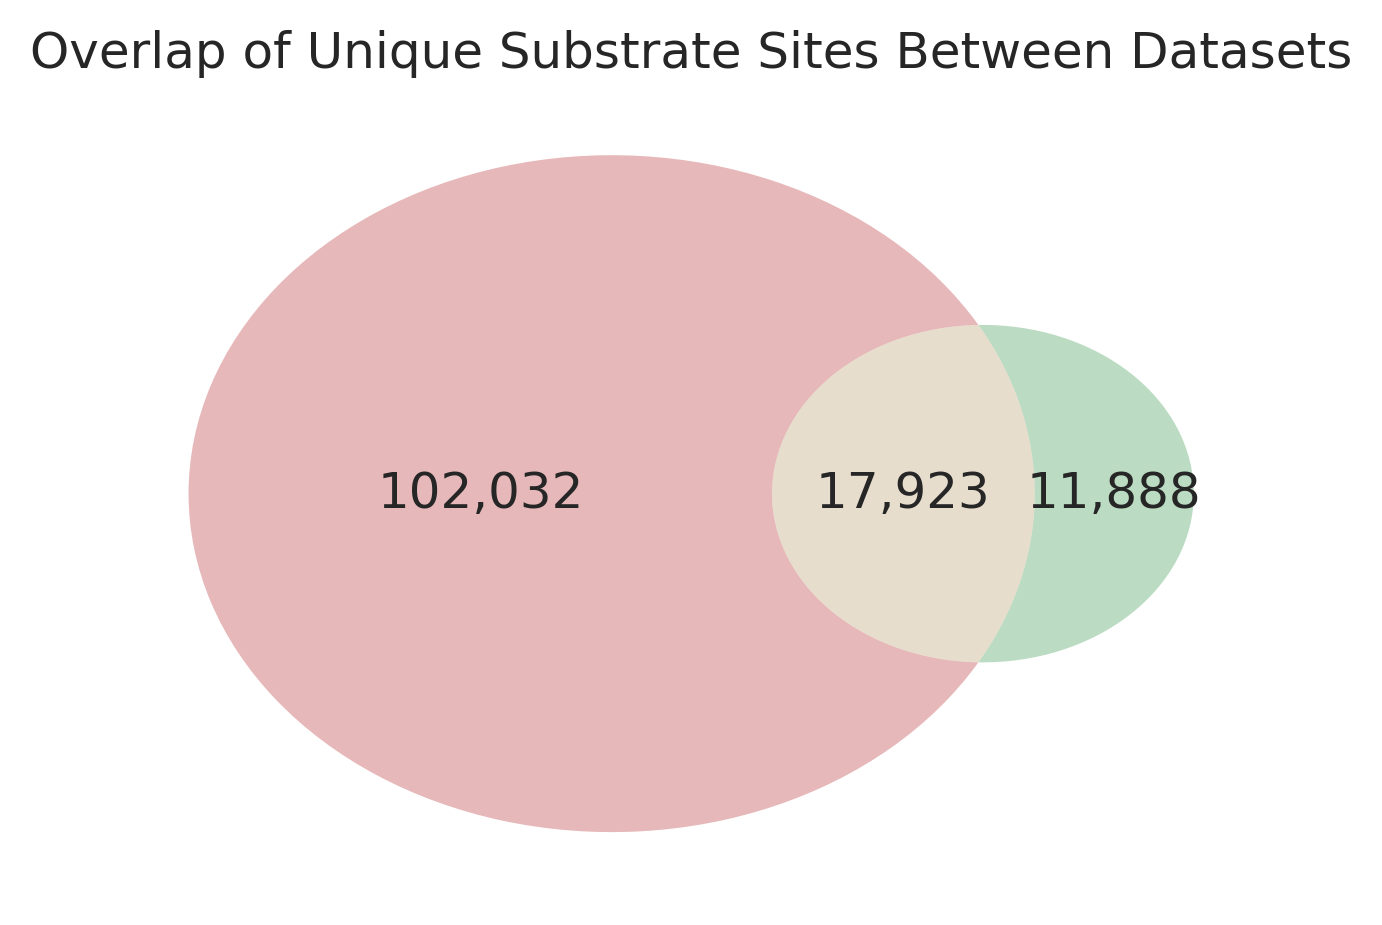

In [ ]:
from matplotlib_venn import venn2

set_human = set(data_site['sub_site'])
set_ks = set(df_site['sub_site'])

plt.figure(figsize=(5,5))
venn = venn2([set_human, set_ks], 
             # set_labels=('Human Phosphoproteome', 'KS Datasets')
             set_labels=('', '')
            )

for label in venn.subset_labels:
    if label:  # Check if the label exists (not empty subset)
        label.set_text(f"{int(label.get_text()):,}")  # Add comma formatting
plt.gca().set_aspect(0.8)
plt.title("Overlap of Unique Substrate Sites Between Datasets")
plt.show()

## Stacked plot of S/T/Y compositions

In [ ]:
df['acceptor']=df['site'].str[0]

In [ ]:
df_sugi = df[df.source=='Sugiyama'].reset_index(drop=True)
df_rest = df[df.source!='Sugiyama'].reset_index(drop=True)

In [ ]:
import matplotlib.ticker as mticker

In [ ]:
def plot_stacked(df,figsize=(6,4)):
    plt.figure(figsize=figsize)
    sns.histplot(data=df, x='source', hue='acceptor', multiple='stack', discrete=True, shrink=0.8)
    
    plt.xlabel('')
    plt.ylabel('Number of Sites')
    plt.title('Total Number of Unique KS Pairs per Source')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # show number with comma
    plt.xticks(rotation=45)

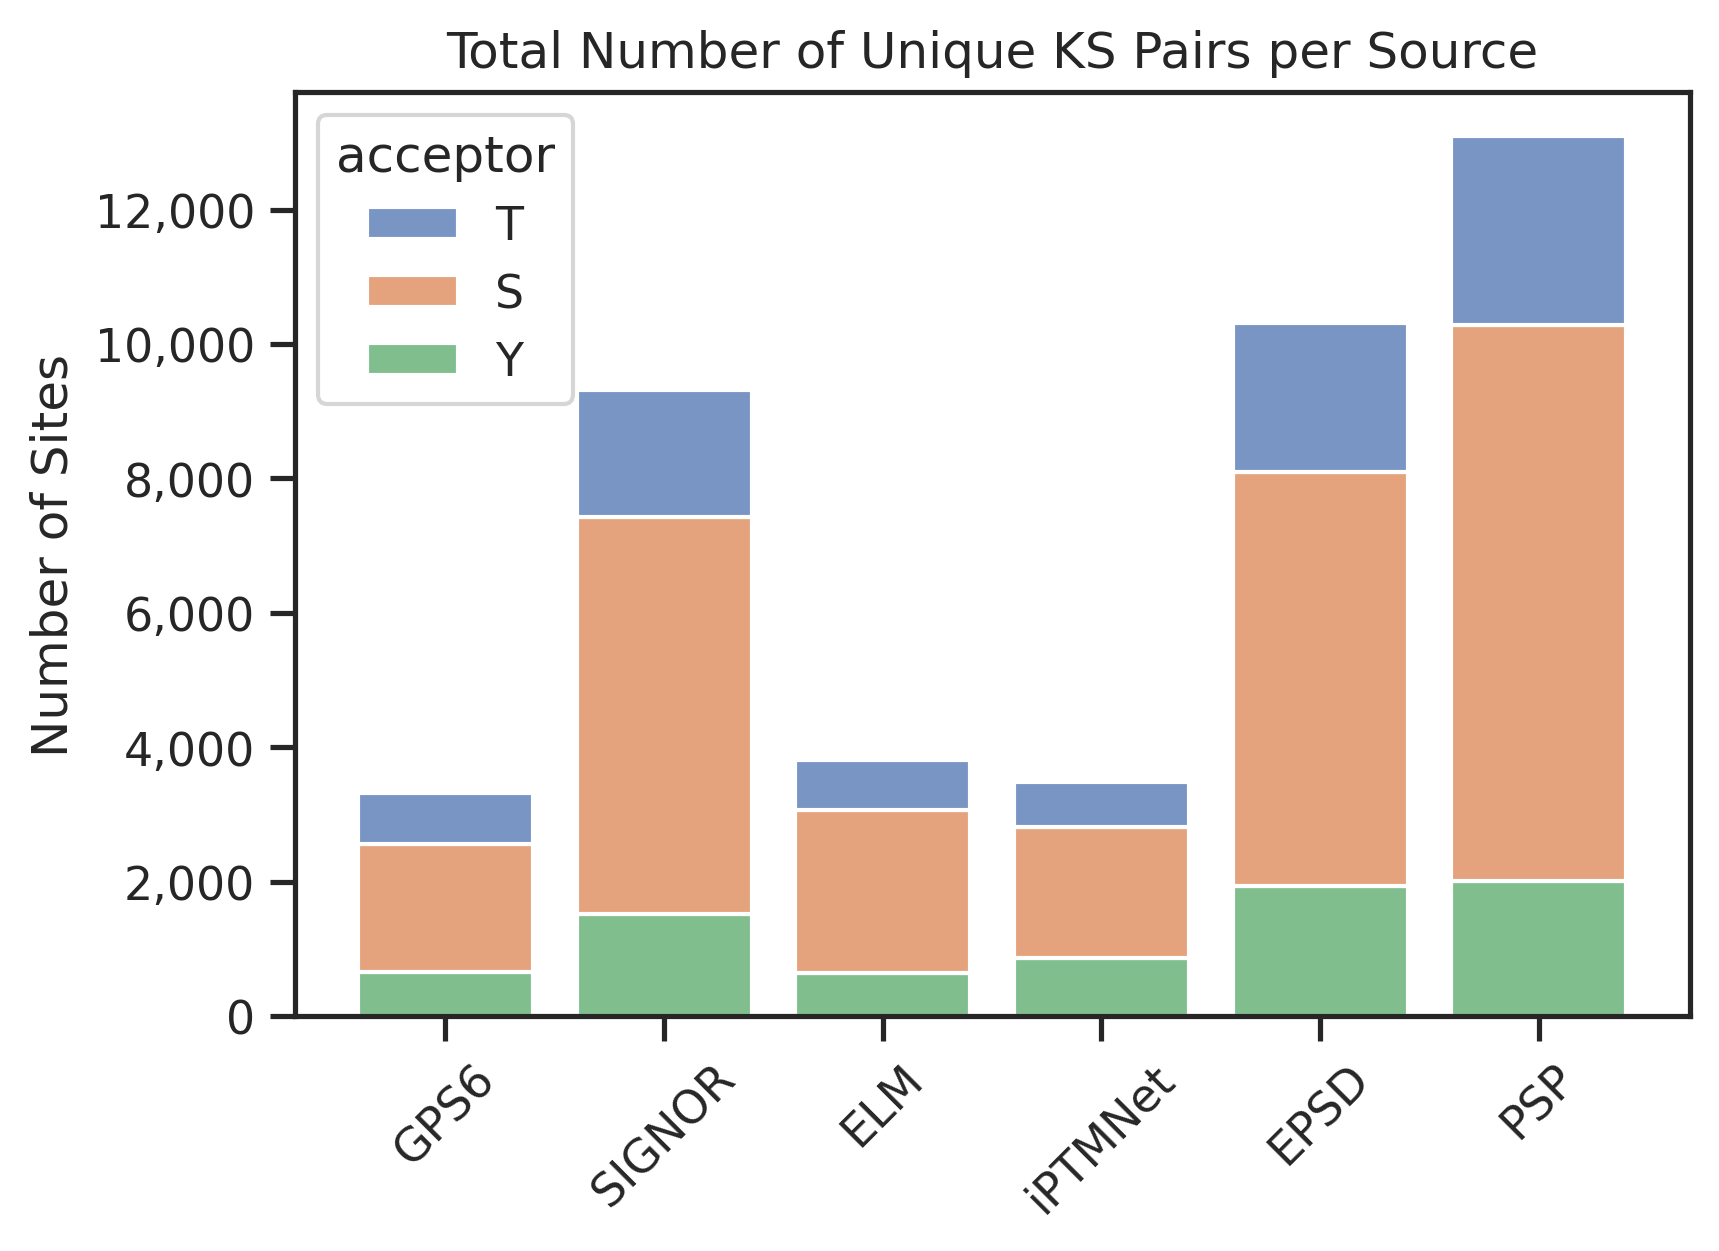

In [ ]:
plot_stacked(df_rest)

In [ ]:
def plot_stacked2(df,figsize=(6,4)):
    plt.figure(figsize=figsize)
    sns.histplot(data=df, x='source', hue='acceptor', multiple='stack', discrete=True, shrink=0.8)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.legend([],frameon=False)
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


Uncomment below to plot the sugiyama site number:

In [ ]:
# plot_stacked2(df_sugi,(0.7,4))

## Recovery rate

Check `raw/recovery_rate.xlsx` for more info.

The data is collected by:
- Filter only human first, get dataframe shape
- After kinase & substrate mapping, get the shape
- After sites validation, get the shape

## Co-occured kinase

In [ ]:
df_group['substrate_uniprot_site']=df_group['substrate_uniprot']+'_'+df_group['site']

In [ ]:
from itertools import combinations
from collections import Counter

In [ ]:
df_group.groupby('substrate_uniprot_site')['kinase_uniprot'].apply(list)

substrate_uniprot_site
A0A2R8Y4L2_S158                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [P48730]
A0A2R8Y4L2_S22                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:

# Count co-occurring kinase pairs
co_occurrence = Counter()
for kinases in grouped:
    for pair in combinations(sorted(set(kinases)), 2):  # remove duplicates and sort for consistency
        co_occurrence[pair] += 1

# print(co_occurrence)

In [ ]:
kinases = set()
for pair in co_occurrence.keys():
    kinases.update(pair)
kinases = sorted(kinases)

# Initialize the co-occurrence matrix with zeros
matrix = pd.DataFrame(0, index=kinases, columns=kinases)

# Fill in the counts (matrix is symmetric)
for (k1, k2), count in co_occurrence.items():
    matrix.loc[k1, k2] = count
    matrix.loc[k2, k1] = count

In [ ]:
matrix['P00533'].sort_values()

P31152      0
Q16659      0
Q16654      0
P37173      0
P35790      0
         ... 
P36888    478
P11362    480
P07949    480
P06213    481
Q15303    497
Name: P00533, Length: 433, dtype: int64

In [ ]:
counts = df_group.groupby('kinase_uniprot').agg({'substrate_uniprot_site':'size'})

Jaccard

In [ ]:

counts_series = counts['substrate_uniprot_site']

# Create a copy for normalized values
norm_matrix = matrix.copy().astype(float)

for k1 in matrix.index:
    for k2 in matrix.columns:
        intersection = matrix.loc[k1, k2]
        union = counts_series[k1] + counts_series[k2] - intersection
        norm_matrix.loc[k1, k2] = intersection / union if union != 0 else 0
    norm_matrix.loc[k1, k1] = 1 # diaganol to be 1

In [ ]:
# Create a boolean mask for the upper triangle (k=1 excludes the diagonal)
mask = np.triu(np.ones(norm_matrix.shape), k=1).astype(bool)
norm_matrix = norm_matrix.where(mask)

In [ ]:
matrix['P00533'].sort_values(ascending=False).head()

Q15303    497
P06213    481
P07949    480
P11362    480
P36888    478
Name: P00533, dtype: int64

In [ ]:
norm_matrix['P00533'].sort_values(ascending=False).head()

O60674    0.253078
O15146    0.213529
P00519    0.203051
O43318    0.122415
O75676    0.023234
Name: P00533, dtype: float64

In [ ]:
kin_info = Data.get_kinase_info()

In [ ]:
st=kin_info[kin_info.group!='TK'].uniprot.tolist()

In [ ]:
st_col =norm_matrix.columns[norm_matrix.columns.isin(st)]

In [ ]:
st_matrix = norm_matrix[st_col]

In [ ]:
def get_max_jaccard(matrix):   
    a = matrix.max()
    b = matrix.idxmax()
    
    matrix = pd.concat([a, b], axis=1)
    matrix.columns = ['jaccard', 'kinase_uniprot']
    
    return matrix.sort_values('jaccard', ascending=False)

In [ ]:
get_max_jaccard(st_matrix)

/tmp/ipykernel_169440/3714721923.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  b = matrix.idxmax()


,jaccard,kinase_uniprot
Q9NYV4,0.509804,Q14004
Q96QP1,0.500000,Q96L96
Q9Y6E0,0.465691,Q9P289
P28482,0.450737,P27361
P31751,0.437574,P31749
...,...,...
O76039,0.000000,O00141
Q2M2I8,0.000000,O00141
O60885,0.000000,O00141
O00311,0.000000,O00141


In [ ]:
tyr=kin_info[kin_info.group=='TK'].uniprot.tolist()
tyr_col =norm_matrix.columns[norm_matrix.columns.isin(tyr)]
tyr_matrix = norm_matrix[tyr_col]

In [ ]:
get_max_jaccard(tyr_matrix)

,jaccard,kinase_uniprot
P54762,0.554638,P54760
Q15375,0.539118,P21709
P54753,0.531496,P29320
Q06418,0.526057,P54762
P54760,0.521168,P54753
...,...,...
P04626,0.046957,O43318
O15146,0.044005,O00506
Q6J9G0,0.016393,O43293
Q6ZMQ8,0.004348,O96017


In [ ]:
kin_info_uniprot = pd.read_excel('raw/uniprot_human_keyword_kinase.xlsx')

In [ ]:
kin_map = kin_info_uniprot.set_index('Entry')['Entry Name'].str.split('_').str[0]

In [ ]:
names = norm_matrix.index.map(kin_map)

todo: Use filter to only select kinase >30 counts

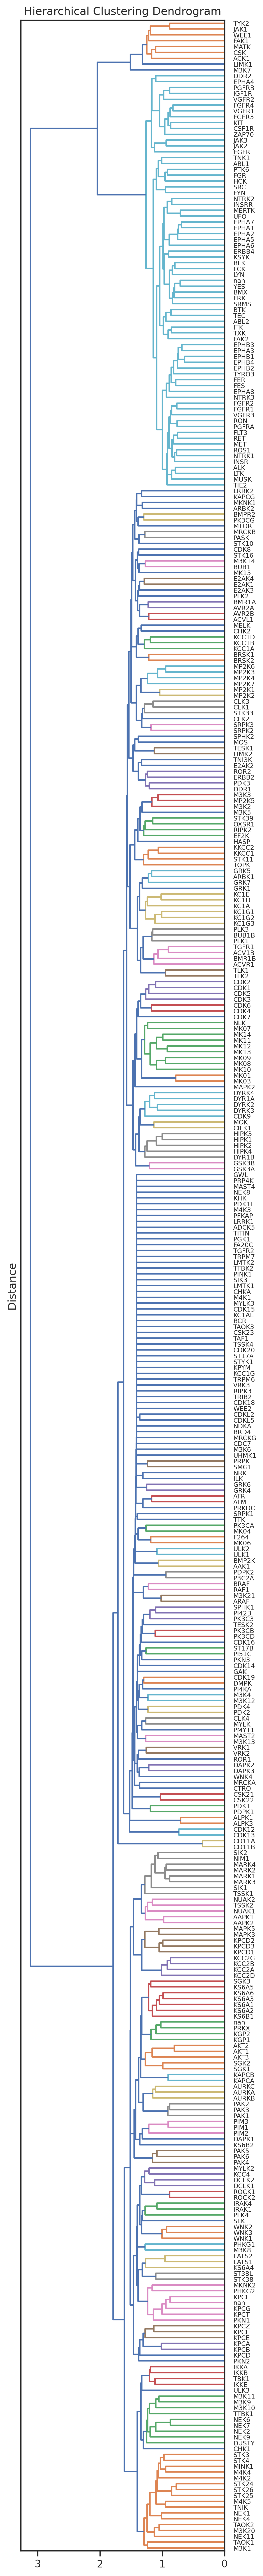

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import MDS
import networkx as nx

# Assuming norm_matrix is your pre-computed Jaccard similarity matrix

# ---------------------------
# 1. Clustering & Heatmap

# Alternatively, using hierarchical clustering with scipy:
# Z = linkage(norm_matrix, method='average')
# plt.figure(figsize=(10, 5))
# dendrogram(Z, labels=norm_matrix.index)
# plt.title("Hierarchical Clustering Dendrogram")
# plt.xlabel("Kinase")
# plt.ylabel("Distance")
# plt.show()

Z = linkage(norm_matrix, method='average')
plt.figure(figsize=(4,50))
dendrogram(Z,orientation='left',leaf_font_size=7,labels=names,color_threshold=1.3)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.show()


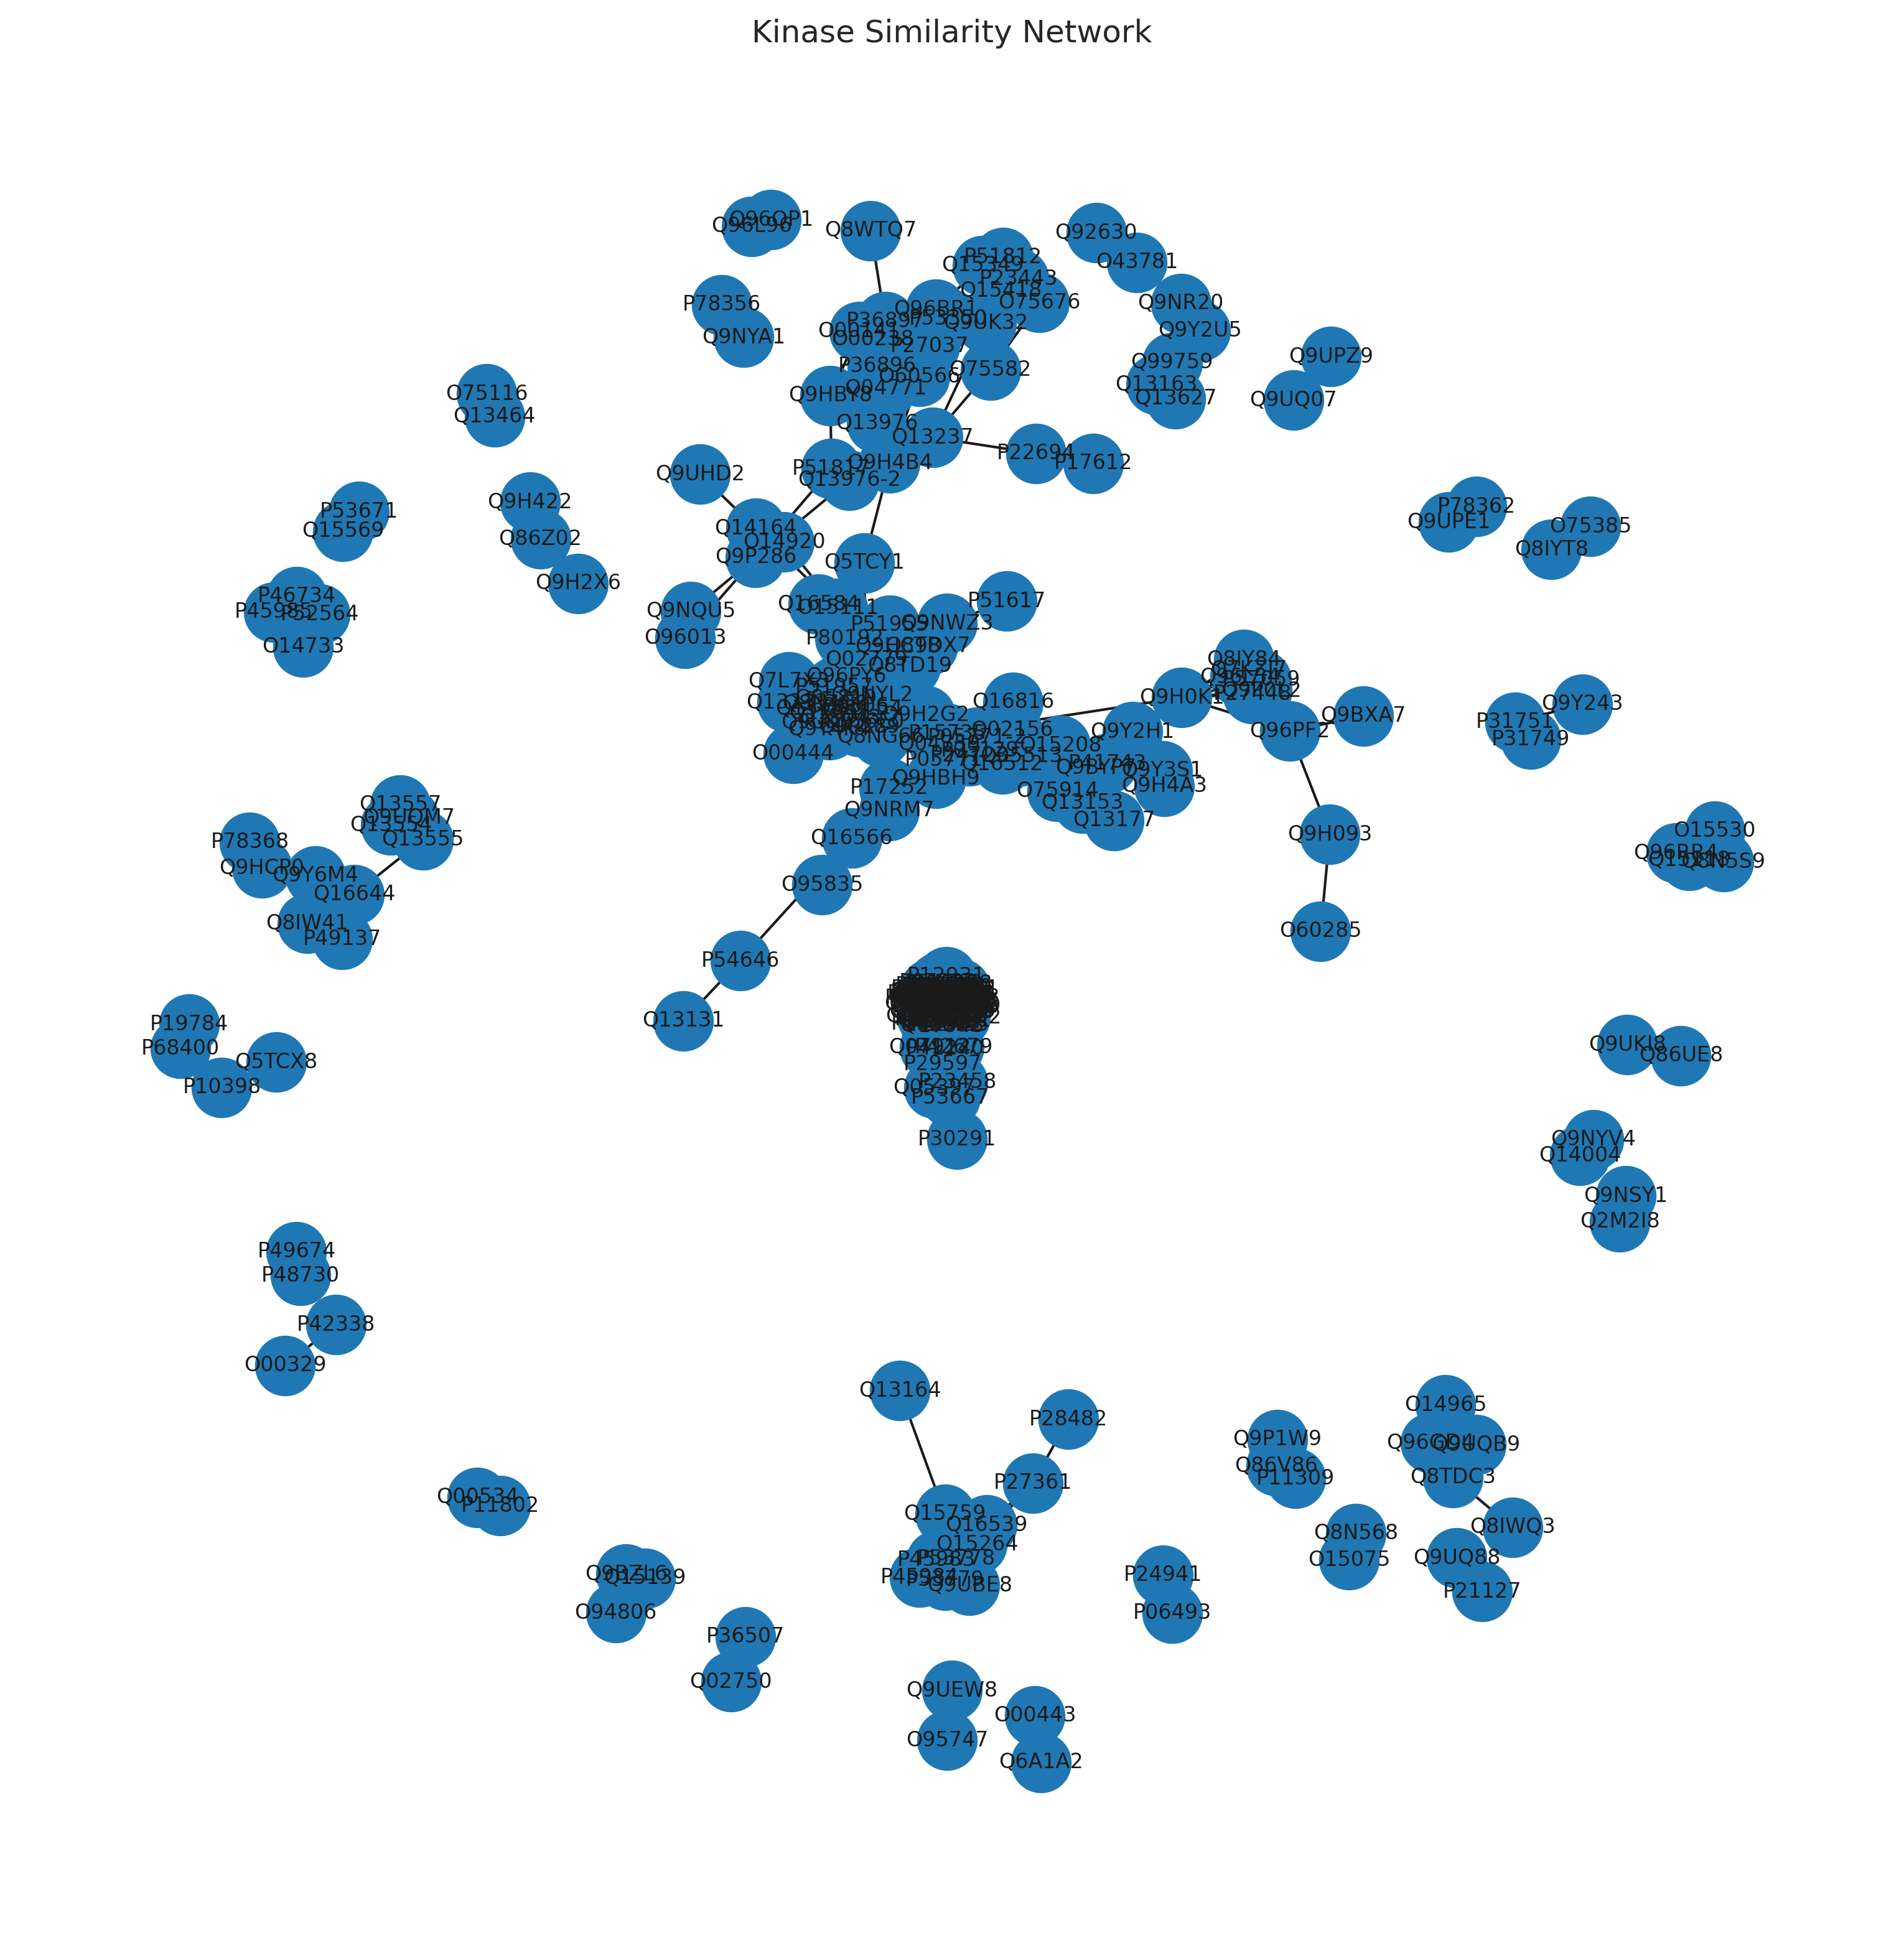

In [ ]:
# 2. Network Analysis
# ---------------------------
# Build a graph from norm_matrix (using a threshold to filter weak links)
threshold = 0.2  # adjust threshold as needed
G = nx.Graph()
for i, kinase1 in enumerate(norm_matrix.index):
    for j, kinase2 in enumerate(norm_matrix.columns):
        if i < j and norm_matrix.loc[kinase1, kinase2] > threshold:
            G.add_edge(kinase1, kinase2, weight=norm_matrix.loc[kinase1, kinase2])

# Draw the network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, weight='weight')
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
plt.title("Kinase Similarity Network")
plt.show()

## Frequency of kinase

Instead of showing PSSM, we can show the neigboring kinase

## Kinase count

In [ ]:
df_group['substrate_uniprot_site']=df_group['substrate_uniprot']+df_group['site']

In [ ]:
counts = df_group.groupby('kinase_uniprot').agg({'substrate_uniprot_site':'size'}).reset_index()

In [ ]:
counts

,kinase_uniprot,substrate_uniprot_site
0,O00141,387
1,O00238,356
2,O00311,50
3,O00329,6
4,O00418,202
...,...,...
450,Q9Y572,10
451,Q9Y5S2,109
452,Q9Y6E0,846
453,Q9Y6M4,224


In [ ]:
kin_info = pd.read_excel('raw/uniprot_human_keyword_kinase.xlsx')

In [ ]:
kin_info = kin_info.rename(columns={'Entry':'kinase_uniprot'})

In [ ]:
kin_info2 = Data.get_kinase_info()

In [ ]:
(kin_info2.in_ST_paper==1).sum()

303

In [ ]:
(kin_info2.in_Tyr_paper==1).sum()

93

In [ ]:
in_pspa=(kin_info2.in_ST_paper==1)|(kin_info2.in_Tyr_paper==1)

In [ ]:
kin_info2[in_pspa]

,kinase,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
0,AAK1,AAK1,Q2M2I8,AAK1,Other,NAK,NaN,NAK,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABL1,ABL1,P00519,ABL1,TK,Abl,NaN,Abl,0,1,...,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
2,ABL2,ABL2,P42684,ABL2,TK,Abl,NaN,Abl,0,1,...,4.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cytoskeleton
3,TNK2,ACK,Q07912,TNK2,TK,Ack,NaN,Ack,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,2.0,vesicle
4,ACVR2A,ACTR2,P27037,ACVR2A,TKL,STKR,STKR2,STKR2,1,0,...,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,cytosol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,YSK1,YSK1,O00506,STK25,STE,STE20,YSK,YSK,1,0,...,6.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,cytosol
519,ZAK,ZAK,Q9NYL2,MAP3K20,TKL,MLK,ZAK,ZAK,1,0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
520,ZAP70,ZAP70,P43403,ZAP70,TK,Syk,NaN,Syk,0,1,...,5.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
521,EEF2K,eEF2K,O00418,EEF2K,Atypical,Alpha,eEF2K,eEF2K,1,0,...,9.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol


In [ ]:
kin_info2[

Index(['kinase', 'ID_coral', 'uniprot', 'ID_HGNC', 'group', 'family',
       'subfamily_coral', 'subfamily', 'in_ST_paper', 'in_Tyr_paper',
       'in_cddm', 'pseudo', 'pspa_category_small', 'pspa_category_big',
       'cddm_big', 'cddm_small', 'length', 'human_uniprot_sequence',
       'kinasecom_domain', 'nucleus', 'cytosol', 'cytoskeleton',
       'plasma membrane', 'mitochondrion', 'Golgi apparatus',
       'endoplasmic reticulum', 'vesicle', 'centrosome', 'aggresome',
       'main_location'],
      dtype='object')

In [ ]:
df_group[df_group.kinase_uniprot=='P07948-2']

,kin_sub_site,kinase_uniprot,substrate_uniprot,site,source,substrate_genes,substrate_sequence,substrate_phosphoseq,substrate_uniprot_site
30312,P07948-2_A0MZ66_Y24,P07948-2,A0MZ66,Y24,Sugiyama,SHTN1 KIAA1598,MNSSDEEKQLQLITSLKEQAIGEYEDLRAENQKTKEKCDKIRQERD...,MNSSDEEKQLQLITSLKEQAIGEyEDLRAENQKTKEKCDKIRQERD...,A0MZ66Y24
30313,P07948-2_A1L429_Y10,P07948-2,A1L429,Y10,Sugiyama,GAGE12B; GAGE12C; GAGE12D; GAGE12E,MSWRGRSTYYWPRPRRYVQPPEMIGPMRPEQFSDEVEPATPEEGEP...,MSWRGRsTyyWPRPRRYVQPPEMIGPMRPEQFSDEVEPATPEEGEP...,A1L429Y10
30314,P07948-2_A1L429_Y9,P07948-2,A1L429,Y9,Sugiyama,GAGE12B; GAGE12C; GAGE12D; GAGE12E,MSWRGRSTYYWPRPRRYVQPPEMIGPMRPEQFSDEVEPATPEEGEP...,MSWRGRsTyyWPRPRRYVQPPEMIGPMRPEQFSDEVEPATPEEGEP...,A1L429Y9
30315,P07948-2_A1X283_Y855,P07948-2,A1X283,Y855,Sugiyama,SH3PXD2B FAD49 KIAA1295 TKS4,MPPRRSIVEVKVLDVQKRRVPNKHYVYIIRVTWSSGSTEAIYRRYS...,MPPRRSIVEVKVLDVQKRRVPNKHYVYIIRVTWSSGSTEAIYRRYS...,A1X283Y855
30316,P07948-2_A5A3E0_S939,P07948-2,A5A3E0,S939,Sugiyama,POTEF A26C1B,MVVEVDSMPAASSVKKPFGLRSKMGKWCCRCFPCCRESGKSNVGTS...,MVVEVDSMPAASSVKKPFGLRSKMGKWCCRCFPCCRESGKSNVGTS...,A5A3E0S939
...,...,...,...,...,...,...,...,...,...
31872,P07948-2_Q9Y5S9_Y54,P07948-2,Q9Y5S9,Y54,Sugiyama,RBM8A RBM8 HSPC114 MDS014,MADVLDLHEAGGEDFAMDEDGDESIHKLKEKAKKRKGRGFGSEEGS...,MADVLDLHEAGGEDFAMDEDGDESIHKLKEKAKKRKGRGFGSEEGS...,Q9Y5S9Y54
31873,P07948-2_Q9Y639_Y216,P07948-2,Q9Y639,Y216,Sugiyama,NPTN SDFR1 SDR1,MSGSSLPSALALSLLLVSGSLLPGPGAAQNAGFVKSPMSETKLTGD...,MSGSSLPSALALSLLLVSGSLLPGPGAAQNAGFVKSPMSETKLTGD...,Q9Y639Y216
31874,P07948-2_Q9Y639_Y220,P07948-2,Q9Y639,Y220,Sugiyama,NPTN SDFR1 SDR1,MSGSSLPSALALSLLLVSGSLLPGPGAAQNAGFVKSPMSETKLTGD...,MSGSSLPSALALSLLLVSGSLLPGPGAAQNAGFVKSPMSETKLTGD...,Q9Y639Y220
31875,P07948-2_Q9Y696_S245,P07948-2,Q9Y696,S245,Sugiyama,CLIC4,MALSMPLNGLKEEDKEPLIELFVKAGSDGESIGNCPFSQRLFMILW...,MALSMPLNGLKEEDKEPLIELFVKAGsDGEsIGNCPFSQRLFMILW...,Q9Y696S245


In [ ]:
counts

,kinase_uniprot,substrate_uniprot_site
0,O00141,387
1,O00238,356
2,O00311,50
3,O00329,6
4,O00418,202
...,...,...
450,Q9Y572,10
451,Q9Y5S2,109
452,Q9Y6E0,846
453,Q9Y6M4,224


In [ ]:
counts.merge(kin_info)

,kinase_uniprot,substrate_uniprot_site,Entry Name,Protein names,Gene Names,uniprot_keyword_kinase,on_tree,Organism,Keywords,Sequence
0,O00141,387,SGK1_HUMAN,Serine/threonine-protein kinase Sgk1 (EC 2.7.1...,SGK1 SGK,1,1,Homo sapiens (Human),3D-structure;Alternative promoter usage;Altern...,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...
1,O00238,356,BMR1B_HUMAN,Bone morphogenetic protein receptor type-1B (B...,BMPR1B,1,1,Homo sapiens (Human),3D-structure;Alternative splicing;ATP-binding;...,MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNI...
2,O00311,50,CDC7_HUMAN,Cell division cycle 7-related protein kinase (...,CDC7 CDC7L1,1,1,Homo sapiens (Human),3D-structure;Alternative splicing;ATP-binding;...,MEASLGIQMDEPMAFSPQRDRFQAEGSLKKNEQNFKLAGVKKDIEK...
3,O00329,6,PK3CD_HUMAN,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",PIK3CD,1,0,Homo sapiens (Human),3D-structure;Adaptive immunity;Alternative spl...,MPPGVDCPMEFWTKEENQSVVVDFLLPTGVYLNFPVSRNANLSTIK...
4,O00418,202,EF2K_HUMAN,Eukaryotic elongation factor 2 kinase (eEF-2 k...,EEF2K,1,1,Homo sapiens (Human),3D-structure;Acetylation;ATP-binding;Calcium;C...,MADEDLIFRLEGVDGGQSPRAGHDGDSDGDSDDEEGYFICPITDDP...
...,...,...,...,...,...,...,...,...,...,...
447,Q9Y572,10,RIPK3_HUMAN,Receptor-interacting serine/threonine-protein ...,RIPK3 RIP3,1,1,Homo sapiens (Human),3D-structure;Alternative splicing;Apoptosis;AT...,MSCVKLWPSGAPAPLVSIEELENQELVGKGGFGTVFRAQHRKWGYD...
448,Q9Y5S2,109,MRCKB_HUMAN,Serine/threonine-protein kinase MRCK beta (EC ...,CDC42BPB KIAA1124,1,1,Homo sapiens (Human),3D-structure;ATP-binding;Cell junction;Cell me...,MSAKVRLKKLEQLLLDGPWRNESALSVETLLDVLVCLYTECSHSAL...
449,Q9Y6E0,846,STK24_HUMAN,Serine/threonine-protein kinase 24 (EC 2.7.11....,STK24 MST3 STK3,1,1,Homo sapiens (Human),3D-structure;Acetylation;Alternative splicing;...,MDSRAQLWGLALNKRRATLPHPGGSTNLKADPEELFTKLEKIGKGS...
450,Q9Y6M4,224,KC1G3_HUMAN,Casein kinase I isoform gamma-3 (CKI-gamma 3) ...,CSNK1G3,1,1,Homo sapiens (Human),3D-structure;Acetylation;Alternative splicing;...,MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVG...


## Source confidence

In [ ]:
df_group.source.str.split('|').str.len().value_counts()

source
1    174536
2      6123
3      3352
4      1312
5       923
6       770
7        50
Name: count, dtype: int64

## Self-phosphorylate

In [ ]:
df_group[df_group['kinase_uniprot']==df_group['substrate_uniprot']].substrate_genes.value_counts().head(20)

substrate_genes
LRRK2 PARK8                  57
TRPM7 CHAK1 LTRPC7           46
MARK2 EMK1                   35
BMX                          34
TTK MPS1 MPS1L1              34
NEK4 STK2                    33
DCLK2 DCAMKL2 DCDC3B DCK2    32
ERBB4 HER4                   32
ABL1 ABL JTK7                32
MARK1 KIAA1477 MARK          31
HIPK2                        31
RPS6KA2 MAPKAPK1C RSK3       29
BTK AGMX1 ATK BPK            29
STK4 KRS2 MST1               28
BUB1B BUBR1 MAD3L SSK1       28
PDGFRA PDGFR2 RHEPDGFRA      28
ITK EMT LYK                  28
RPS6KA6 RSK4                 28
PRKD2 PKD2 HSPC187           28
ABL2 ABLL ARG                27
Name: count, dtype: int64

In [ ]:
df_group.source

source
Sugiyama                     167633
EPSD|PSP                       3346
PSP                            2932
SIGNOR                         1984
SIGNOR|EPSD|PSP                1878
                              ...  
GPS6|SIGNOR|ELM|Sugiyama          1
ELM|iPTMNet|Sugiyama              1
ELM|iPTMNet|EPSD|Sugiyama         1
iPTMNet|PSP|Sugiyama              1
SIGNOR|ELM|EPSD|Sugiyama          1
Name: count, Length: 111, dtype: int64

### Nearby co-occured kinase